In [2]:

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import numpy as np
import json
from tabulate import tabulate
from tqdm import trange
import random
import seaborn as sns
from sklearn.metrics import classification_report, recall_score,precision_score , f1_score, accuracy_score
import sys
# sys.path.append("HateRecognition/target_model/")
from utils import preprocessing, load_anno_data, data_loader, define_target, create_model
from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from sklearn.model_selection import StratifiedKFold
from hdbscan import HDBSCAN
from sklearn.metrics import confusion_matrix
sys.path.append(r"/sise/home/shouei/HateRecognition/target_model/TopicTuner/")
from topictuner import TopicModelTuner as TMT
# torch.cuda.empty_cache()


In [77]:



# df = load_anno_data()
# sys.path.append("/sise/home/shouei/HateRecognition/data/")
df = pd.read_csv(r'../data/annotated_target_topic_data.csv')
# df = pd.read_csv(r'./HateRecognition/data/annotated_target_topic_data.csv')
hate_df = df[df['label']=='hatespeech'].reset_index()
# docs = [' '.join(x) for x in df.tokens.values]
# hate_df = hate_df[hate_df['target'].isin({'Asian', 'Other', 'None', 'Women', 'Hispanic'})]
hate_df.loc[hate_df['target']=='Arab','target'] = 'Islam'
labels_counter = Counter(hate_df.target.tolist())
# hate_df[~hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))] = 'other'
# hate_df = hate_df[hate_df['target'].isin(x[0] for x in labels_counter.most_common(4))]
# hate_df.to_csv("./HateRecognition/data/filtered_hatexplain_data.csv")

In [78]:
hate_df.loc[~ hate_df['target'].isin(x[0] for x in labels_counter.most_common(4)),'target'] = 'other'

In [49]:
# hate_df = pd.read_csv(r'../data/filtered_hatexplain_data.csv')


In [79]:
import sklearn
le = sklearn.preprocessing.LabelEncoder()
text = hate_df.text.values
print(hate_df.target.unique())
labels = le.fit_transform(hate_df.target.values)
unique_labels= list(set(labels))
num_labels= len(unique_labels)

['other' 'Jewish' 'African' 'Islam' 'Homosexual']


In [80]:
le.transform(['African', 'Homosexual', 'Islam', 'Jewish', 'other'])

array([0, 1, 2, 3, 4])

In [81]:
topic_model = BERTopic.load('../target_model/topic_model_with_other')
topics, probs = topic_model.transform(text)
hate_df['topic'] = topics

<AxesSubplot:>

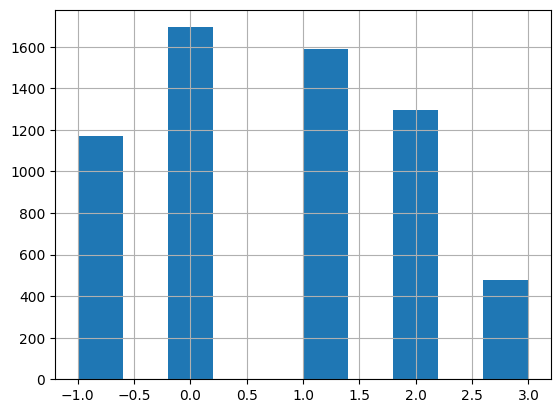

In [93]:
hate_df.topic.hist()

In [83]:
topic_model.topic_names

{-1: '-1_user_nigger_number_white',
 0: '0_nigger_white_niggers_like',
 1: '1_moslem_muslim_sand_number',
 2: '2_kike_jews_jew_white',
 3: '3_faggots_faggot_user_queers'}

In [84]:
Counter(labels.tolist())

Counter({4: 1053, 3: 1131, 0: 2125, 2: 1387, 1: 538})

In [85]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True,
    truncation=True
    )

In [86]:
token_id = []
attention_masks = []
with_topic=True
MAX_LEN = max([len(x.split()) for x in text])
print(MAX_LEN)
for i, sample in enumerate(text):
  topic_name = None
  if with_topic:
    topic_id = topics[i]
    topic_name = topic_model.topic_names[topic_id]
    topic_name = ' '.join(topic_name.split('_')[1:])
  encoding_dict = preprocessing(sample,tokenizer, MAX_LEN, topic_name)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

165


In [87]:
n=5
seed = 42
kf = StratifiedKFold(n_splits=n, random_state=seed, shuffle=True)
is_kf = False
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)
if is_kf:
    split_range = kf.split(text, labels)
else:
    split_range = [(train_idx, val_idx)]


In [88]:
import gc
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Run on GPU
# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
results = []
for train_idx, val_idx in split_range:
    torch.cuda.empty_cache()
    gc.collect()
    model, optimizer = create_model(num_labels)
    model = model.to(device)
    train_dataloader, validation_dataloader = data_loader(token_id, attention_masks, labels, train_idx, val_idx, batch_size)
    accuracy_scores = {'train':[], 'val':[]}
    losses_scores = {'train':[], 'val':[]}
    for epoch in trange(epochs, desc = 'Epoch'):

        # ========== Training ==========

        # Set model to training mode
        model.train()

        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        # Tracking variables 
        true_labels = []
        pred_labels = []
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # b_labels = b_labels.type(torch.LongTensor)
            optimizer.zero_grad()
            # Forward pass
            train_output = model(b_input_ids, 
                                 token_type_ids = None, 
                                 attention_mask = b_input_mask, 
                                 labels = b_labels)
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            # Update tracking variables
            
            
            
#             class_weights=class_weight.compute_class_weight('balanced',np.unique(y),y.numpy())
#             class_weights=torch.tensor(class_weights,dtype=torch.float)

#             print(class_weights) #([1.0000, 1.0000, 4.0000, 1.0000, 0.5714])
#             logits = outputs['logits']
#             criterion = torch.nn.CrossEntropyLoss(weights=class_weights)
#             loss = criterion(logits, inputs['labels'])
            
            
            
            tr_loss += train_output.loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
            preds = torch.argmax(train_output.logits, dim=1)
            true_labels.extend(b_labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
        # Calculate the evaluation metrics
        tr_accuracy = accuracy_score(true_labels, pred_labels)
        precision = recall_score(true_labels, pred_labels, average='macro')
        recall = precision_score(true_labels, pred_labels, average='macro')
        f1 = f1_score(true_labels, pred_labels, average='macro')
        losses_scores['train'].append(tr_loss/nb_tr_steps)
        accuracy_scores['train'].append(tr_accuracy)
        train_text_to_print = f'Epoch {epoch+1}:\nTrain evaluation\nloss = {tr_loss/nb_tr_steps:.3f} accuracy = {tr_accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'

        # Set model to evaluation mode
        model.eval()

        # Tracking variables 
        true_labels = []
        pred_labels = []
        ts_loss = 0
        nb_ts_steps = 0
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # b_labels = b_labels.type(torch.LongTensor)
            # with torch.no_grad():
            # Forward pass
            eval_output = model(b_input_ids, 
                                token_type_ids = None, 
                                attention_mask = b_input_mask,
                                labels = b_labels)
            # logits = eval_output.logits.detach().cpu().numpy()
            # label_ids = b_labels.to('cpu').numpy()
            # Convert the logits to predictions
            preds = torch.argmax(eval_output.logits, dim=1)
            true_labels.extend(b_labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            ts_loss += eval_output.loss.item()
            nb_ts_steps += 1
        # Calculate the evaluation metrics
        ts_accuracy = accuracy_score(true_labels, pred_labels)
        precision = recall_score(true_labels, pred_labels, average='macro')
        recall = precision_score(true_labels, pred_labels, average='macro')
        f1 = f1_score(true_labels, pred_labels, average='macro')
        losses_scores['val'].append(ts_loss/nb_ts_steps)
        accuracy_scores['val'].append(ts_accuracy)
        # Print the evaluation metrics
        val_text_to_print = f'Validation evaluation\nloss = {ts_loss/nb_ts_steps:.3f} accuracy = {ts_accuracy:.3f}, precision = {precision:.3f}, recall = {recall:.3f}, f1 = {f1:.3f}\n'
        print(train_text_to_print+val_text_to_print)
    if epoch<epochs-1:
        del model
        del train_output
        del eval_output
    results.append((tr_accuracy, ts_accuracy))

cuda


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1:
Train evaluation
loss = 1.140 accuracy = 0.560, precision = 0.480, recall = 0.525, f1 = 0.475
Validation evaluation
loss = 0.797 accuracy = 0.728, precision = 0.713, recall = 0.682, f1 = 0.689



Epoch:  20%|██        | 2/10 [01:00<04:02, 30.35s/it]

Epoch 2:
Train evaluation
loss = 0.711 accuracy = 0.765, precision = 0.740, recall = 0.735, f1 = 0.729
Validation evaluation
loss = 0.610 accuracy = 0.789, precision = 0.778, recall = 0.764, f1 = 0.754



Epoch:  30%|███       | 3/10 [01:31<03:33, 30.44s/it]

Epoch 3:
Train evaluation
loss = 0.508 accuracy = 0.837, precision = 0.818, recall = 0.812, f1 = 0.812
Validation evaluation
loss = 0.506 accuracy = 0.834, precision = 0.804, recall = 0.821, f1 = 0.807



Epoch:  40%|████      | 4/10 [02:01<03:02, 30.49s/it]

Epoch 4:
Train evaluation
loss = 0.387 accuracy = 0.875, precision = 0.860, recall = 0.860, f1 = 0.858
Validation evaluation
loss = 0.463 accuracy = 0.851, precision = 0.819, recall = 0.838, f1 = 0.826



Epoch:  50%|█████     | 5/10 [02:32<02:32, 30.51s/it]

Epoch 5:
Train evaluation
loss = 0.317 accuracy = 0.901, precision = 0.888, recall = 0.892, f1 = 0.889
Validation evaluation
loss = 0.446 accuracy = 0.866, precision = 0.844, recall = 0.863, f1 = 0.849



Epoch:  60%|██████    | 6/10 [03:02<02:02, 30.53s/it]

Epoch 6:
Train evaluation
loss = 0.262 accuracy = 0.919, precision = 0.906, recall = 0.911, f1 = 0.907
Validation evaluation
loss = 0.449 accuracy = 0.871, precision = 0.857, recall = 0.861, f1 = 0.857



Epoch:  70%|███████   | 7/10 [03:33<01:31, 30.53s/it]

Epoch 7:
Train evaluation
loss = 0.219 accuracy = 0.936, precision = 0.926, recall = 0.932, f1 = 0.928
Validation evaluation
loss = 0.452 accuracy = 0.864, precision = 0.856, recall = 0.849, f1 = 0.851



Epoch:  80%|████████  | 8/10 [04:03<01:01, 30.53s/it]

Epoch 8:
Train evaluation
loss = 0.176 accuracy = 0.950, precision = 0.943, recall = 0.949, f1 = 0.945
Validation evaluation
loss = 0.498 accuracy = 0.856, precision = 0.833, recall = 0.846, f1 = 0.839



Epoch:  90%|█████████ | 9/10 [04:34<00:30, 30.53s/it]

Epoch 9:
Train evaluation
loss = 0.147 accuracy = 0.957, precision = 0.951, recall = 0.956, f1 = 0.953
Validation evaluation
loss = 0.506 accuracy = 0.864, precision = 0.851, recall = 0.853, f1 = 0.852



Epoch: 100%|██████████| 10/10 [05:05<00:00, 30.50s/it]

Epoch 10:
Train evaluation
loss = 0.122 accuracy = 0.966, precision = 0.960, recall = 0.964, f1 = 0.962
Validation evaluation
loss = 0.555 accuracy = 0.857, precision = 0.840, recall = 0.848, f1 = 0.841



In [94]:
model.save_pretrained('finetune_topic_other')

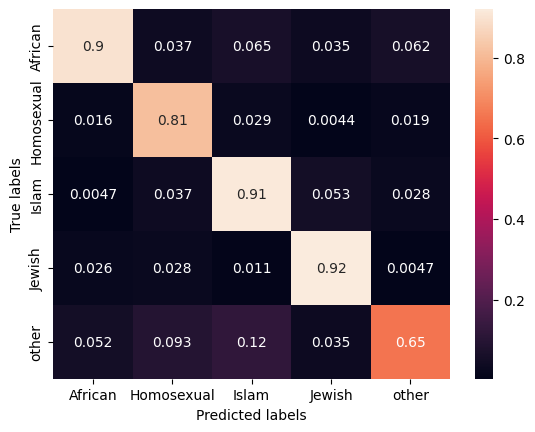

In [90]:
cf_matrix = confusion_matrix(le.inverse_transform(true_labels), le.inverse_transform(pred_labels), labels=le.classes_)
cf_matrix = pd.DataFrame(cf_matrix, columns=le.classes_, index=le.classes_)
import matplotlib.pyplot as plt  
ax= plt.subplot()
sns.heatmap(cf_matrix/np.sum(cf_matrix, axis=1), annot=True, ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 

In [ ]:
len(true_labels)

1037

In [ ]:
sum([true_labels[i]==pred_labels[i] for i in range(len(true_labels))])/len(true_labels)

0.9200415368639667

In [ ]:
pd.DataFrame(results, columns=['tr_acc', 'val_acc']).mean(axis=0)

tr_acc     0.988309
val_acc    0.919003
dtype: float64

In [ ]:
new_sentence = 'all they think about it is rap, guns and drugs'
topic_id = topic_model.transform([new_sentence])[0][0]
topic_name = topic_model.topic_names[topic_id]
encoding_dict = preprocessing(new_sentence, tokenizer, MAX_LEN, topic_name)
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []


# Extract IDs and Attention Mask
test_ids.append(encoding_dict['input_ids'])
test_attention_mask.append(encoding_dict['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = le.inverse_transform([output.logits.cpu().data.numpy().argmax()])


print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)
print("Topic name: ", topic_name)

Tue Jan 17 15:10:23 2023 Worst tree score: 0.19185485
Tue Jan 17 15:10:23 2023 Mean tree score: 0.20397178
Tue Jan 17 15:10:23 2023 Best tree score: 0.21212121
Tue Jan 17 15:10:23 2023 Forward diversification reduced edges from 25905 to 16687
Tue Jan 17 15:10:23 2023 Reverse diversification reduced edges from 16687 to 16687
Tue Jan 17 15:10:23 2023 Degree pruning reduced edges from 18344 to 17680
Tue Jan 17 15:10:23 2023 Resorting data and graph based on tree order
Tue Jan 17 15:10:23 2023 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

Input Sentence:  all they think about it is rap, guns and drugs
Predicted Class:  ['African']
Topic name:  0_nigger_white_niggers_number


<AxesSubplot:title={'center':'Loss'}>

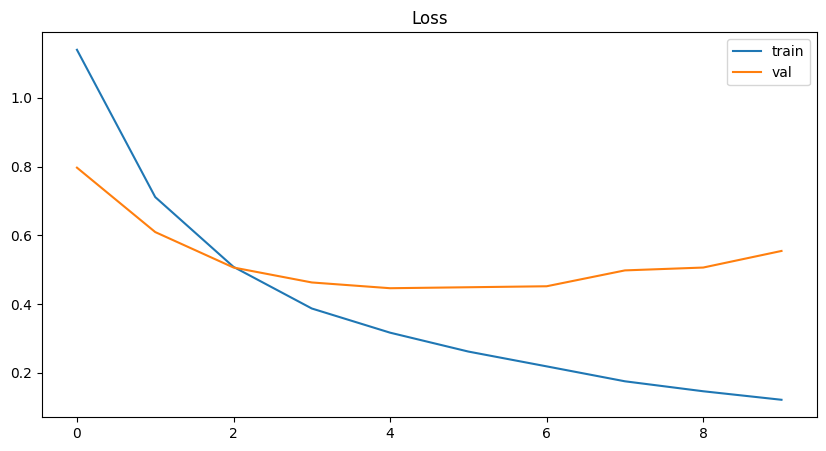

In [91]:
pd.DataFrame(losses_scores).plot(title='Loss',figsize=(10,5))

<AxesSubplot:title={'center':'Accuracy'}>

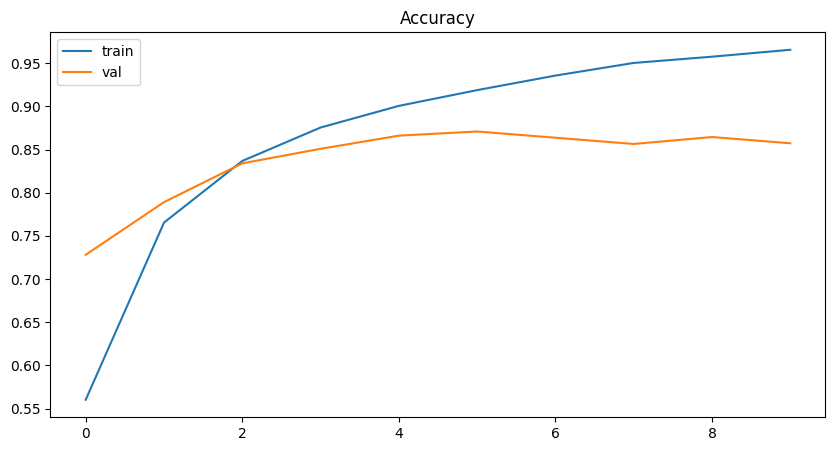

In [92]:
pd.DataFrame(accuracy_scores).plot(title='Accuracy',figsize=(10,5))

In [76]:
hate_df

,index,Unnamed: 0.1,Unnamed: 0,label,target,tokens,text,topic
0,3,3,1179088797964763136_twitter,hatespeech,other,"['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",<user> i am bit confused coz chinese ppl can n...,-1
1,4,4,1179085312976445440_twitter,hatespeech,other,"['this', 'bitch', 'in', 'whataburger', 'eating...",this bitch in whataburger eating a burger with...,0
2,5,5,13851720_gab,hatespeech,Jewish,"['laura', 'loomer', 'raped', 'me', 'while', 's...",laura loomer raped me while screaming at me in...,1
3,6,6,24198545_gab,hatespeech,African,"['and', 'this', 'is', 'why', 'i', 'end', 'up',...",and this is why i end up with nigger trainee d...,0
4,8,8,19679648_gab,hatespeech,African,"['guilty', 'until', 'proven', 'innocent', 'unl...",guilty until proven innocent unless you are a ...,2
...,...,...,...,...,...,...,...,...
6229,20128,20128,9867117_gab,hatespeech,Islam,"['well', 'my', 'dear', 'lgbtq', 'brothers', 'a...",well my dear lgbtq brothers and sisters i do n...,1
6230,20134,20134,9875482_gab,hatespeech,African,"['c', 'mon', 'men', 'charge', 'it', 'for', 'th...",c mon men charge it for the gays trannies musl...,1
6231,20138,20138,9981407_gab,hatespeech,Jewish,"['<user>', 'congrats', 'on', 'making', 'the', ...",<user> congrats on making the kike hate list w...,2
6232,20140,20140,9982674_gab,hatespeech,Islam,"['more', 'and', 'more', 'leftists', 'are', 'mo...",more and more leftists are moving closer to ce...,1


In [41]:
hate_df

,index,Unnamed: 0.1,Unnamed: 0,label,target,tokens,text,topic
0,3,3,1179088797964763136_twitter,hatespeech,other,"['<user>', 'i', 'am', 'bit', 'confused', 'coz'...",<user> i am bit confused coz chinese ppl can n...,2
1,4,4,1179085312976445440_twitter,hatespeech,other,"['this', 'bitch', 'in', 'whataburger', 'eating...",this bitch in whataburger eating a burger with...,0
2,5,5,13851720_gab,hatespeech,Jewish,"['laura', 'loomer', 'raped', 'me', 'while', 's...",laura loomer raped me while screaming at me in...,3
3,6,6,24198545_gab,hatespeech,African,"['and', 'this', 'is', 'why', 'i', 'end', 'up',...",and this is why i end up with nigger trainee d...,0
4,8,8,19679648_gab,hatespeech,African,"['guilty', 'until', 'proven', 'innocent', 'unl...",guilty until proven innocent unless you are a ...,1
...,...,...,...,...,...,...,...,...
6229,20128,20128,9867117_gab,hatespeech,Islam,"['well', 'my', 'dear', 'lgbtq', 'brothers', 'a...",well my dear lgbtq brothers and sisters i do n...,2
6230,20134,20134,9875482_gab,hatespeech,African,"['c', 'mon', 'men', 'charge', 'it', 'for', 'th...",c mon men charge it for the gays trannies musl...,2
6231,20138,20138,9981407_gab,hatespeech,Jewish,"['<user>', 'congrats', 'on', 'making', 'the', ...",<user> congrats on making the kike hate list w...,1
6232,20140,20140,9982674_gab,hatespeech,Islam,"['more', 'and', 'more', 'leftists', 'are', 'mo...",more and more leftists are moving closer to ce...,2


In [ ]:
import sweetviz as sv


In [ ]:
my_report = sv.analyze(hate_df)
my_report

c:\Users\Administrator\.conda\envs\py310\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\Administrator\.conda\envs\py310\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

c:\Users\Administrator\.conda\envs\py310\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
c:\Users\Administrator\.conda\envs\py310\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
c:\Users\Administrator\.conda\envs\py310\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
c:\Users\Administrator\.conda\envs\py310\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be re

In [ ]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
